In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [36]:
path = '/Users/bavi_tesh/Documents/GitHub/PatternRecognition/Assignments/HW 4/lfw'

In [37]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [38]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


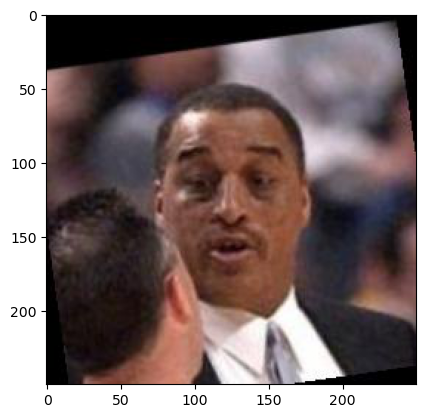

In [39]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Because they produce a condensed representation of the input data, autoencoders (AEs) are useful for data compression tasks such as signal or image compression. Additionally, they are skilled at feature learning, which involves removing pertinent aspects for programs like picture identification. Moreover, AEs can be used to remove artifacts or noise from photos during image reconstruction. An encoder-decoder structure with a deterministic latent space, where each input maps to a distinct point, makes up the architecture of AEs. Mean Squared Error (MSE), which minimizes the difference between input and reconstructed output, is the loss function that is most frequently utilized. Variational Autoencoders (VAEs), on the other hand, excel in generative modeling because they make it possible to create fresh samples that closely resemble the training set. During training, their probabilistic encoder uses a reparameterization method, and VAEs  use a more complex loss function, combining a reconstruction loss with a regularization term known as Kullback-Leibler (KL) divergence. VAEs are preferred for generative tasks, latent space interpolation, and anomaly detection, showcasing their versatility beyond traditional compression and feature learning applications of AEs





# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_channels, input_size, latent_dim):
        super(VAE, self).__init__()
        self.input_channels = input_channels
        self.input_size = input_size
        self.latent_dim = latent_dim

        # Encoder layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * (input_size // 4) * (input_size // 4), 1024)
        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 1024)
        self.fc4 = nn.Linear(1024, 64 * (input_size // 4) * (input_size // 4))
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1)

    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def decoder(self, z):
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = x.view(x.size(0), 64, (self.input_size // 4), (self.input_size // 4))
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, logvar

# Example usage:
input_channels = 1  # For grayscale images
input_size = 28  # Assuming square input images
latent_dim = 20

vae_model = VAE(input_channels, input_size, latent_dim)


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.


When encoding input data into latent states, traditional autoencoders produce a single value for every dimension, while VAEs introduce an important distinction. For every dimension, VAEs yield a Gaussian probability distribution with a mean and standard deviation. VAEs provide seven probability distributions, for example, if the latent space has seven dimensions. Taken together, these probability distributions express the state as a probability distribution over space.
By treating each component of the new vector as a random variable, this method enables the mean and variance vectors to be combined into a single, cohesive representation. It is implied that these vectors have the ability to be combined effectively when viewed as random variables.
After we comprehend the encoding of our data, we decode it by sampling across all variables and choosing a random number from the distribution that produced the encoding. This sampled number is then sent to the decoder, which decodes it again into a form that can be understood.
In conclusion, the encoder network converts input data into the latent space, which is symbolized by a normal distribution's mean and log-variance. Using these settings, the sampling step creates new points in the latent space by taking a sample from this normal distribution. The parameters of the normal distribution used to sample latent variables are mean and variance. These sampled latent variables are then fed into the decoder network, which maps them back to the original data space. This method captures the spirit of VAEs, offering a probabilistic approach to encoding and decoding latent representations.

In [59]:
import torch
from torchvision import transforms
from PIL import Image

# Taking Sample image. PATH OF THAT.
image_path = '/Users/bavi_tesh/Documents/GitHub/PatternRecognition/Assignments/HW 4/lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg'

# Define a transform to preprocess the image
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Adjust size based on your model's input size
    transforms.ToTensor()
])

# Load and preprocess the image
image = Image.open(image_path).convert('L')  # Convert to grayscale
image = transform(image)
image = image.view(1, -1)  # Flatten the image to a 1D tensor

# Instantiate the VAE model
input_dim = image.size(1)
latent_dim = 20  # Assuming a latent space dimension of 20

# Pass the image through the VAE
output_reconstructed, mean, logvar = model(image)

# Print the shape of the output of the encoder
print("The enocder has two ouptuts Mean and Variance and the shape is", mean.shape)

# Explanation for generating new samples in the latent space:
# To generate new samples in the latent space, you can sample from a normal distribution using the mean and log variance obtained from the encoder.
# Formula: z = mean + epsilon * std, where epsilon is sampled from N(0, 1) and std = exp(0.5 * logvar)

# Generate a new sample in the latent space
sampled_latent = model.reparameterize(mean, logvar)

# Use the decoder to create a new image from the sampled latent vector
generated_image = model.decoder(sampled_latent)

# Print the shape of the vector that feeds to decoder
print("The shape of the vector which is feeding to decoder:", generated_image.shape)

# Verify that the forward pass is working correctly
print("The shape of the image from decoder is:", output_reconstructed.shape)

The enocder has two ouptuts Mean and Variance and the shape is torch.Size([1, 128])
The shape of the vector which is feeding to decoder: torch.Size([1, 128])
The shape of the image from decoder is: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.

The reconstruction loss and the Kullback-Leibler (KL) divergence are the two fundamental parts of the loss function when it comes to variational autoencoders (VAEs). The goal of the reconstruction loss is to minimize information loss during the encoding and decoding processes by assessing how closely the decoder's output adheres to the original input. This term, which is usually calculated using Mean Squared Error (MSE) or comparable metrics, encourages the VAE to produce reconstructions that accurately reflect the input data. However, the KL divergence guides the latent space to conform to a particular probability distribution, which is often a unit Gaussian, acting as a regularization term. The VAE ensures a well-structured latent space, which makes smoother interpolation and sample generation possible, by decreasing the KL divergence.To put it simply, the VAE loss function creates a fine balance between regularizing the latent space and accurately reconstructing data, which allows the model to acquire a meaningful and organized representation that is useful for tasks like data creation and interpolation.



In [61]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_trainable_params}")

Total Trainable Parameters: 12810691


In [23]:
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [67]:
kl = -0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
kl_loss = kl.sum() / inputs.size(0)
fit = 0.5 * (outputs - inputs).pow(2)
fit_loss = fit.sum() / inputs.size(0)
loss_function = kl_loss + fit_loss

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In situations where a machine learning model's loss does not reduce throughout training, a methodical troubleshooting strategy is required. First, the learning rate needs to be carefully examined because a number that is too high could impede convergence or result in repetitive optimization patterns. It is essential to modify the learning rate to an ideal level. Furthermore, the representational capacity of the model can be affected by changing its architectural features, such as the dimension of the latent space and the number of kernels in convolutional layers. Other approaches to solve the problem include experimenting with different batch sizes and switching the optimizer from Adam to Stochastic Gradient Descent (SGD). Through recurrent evaluation and modification of these variables, the training process can be troubleshooted and optimized, leading to a reduction in the loss and enhancing overall model performance.

In [24]:
import torchvision.transforms.functional as Fa

num_epochs = 20

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training loop
    for inputs, _ in dataloader:
        inputs = inputs.to(device)  # Move data to GPU
        optim.zero_grad()  # Zero the gradients

        # Forward pass
        outputs, mu, logvar = model(inputs)

        # Compute KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / inputs.size(0)

        # Compute reconstruction (fit) loss
        fit_loss = 0.5 * torch.sum((outputs - inputs).pow(2)) / inputs.size(0)

        # Total loss
        loss = kl_loss + fit_loss

        # Backward pass
        loss.backward()

        # Update weights
        optim.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Print loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

Epoch [1/20], Loss: 4934888.829612253
Epoch [2/20], Loss: 2052.623929083635
Epoch [3/20], Loss: 1815.9857012615112
Epoch [4/20], Loss: 1692.748948249264
Epoch [5/20], Loss: 1634.4918321987282
Epoch [6/20], Loss: 1540.7257693378247
Epoch [7/20], Loss: 1496.9247206535892
Epoch [8/20], Loss: 1454.7790394658628
Epoch [9/20], Loss: 1432.5830417209202
Epoch [10/20], Loss: 1419.6142480822577
Epoch [11/20], Loss: 1399.9052908339938
Epoch [12/20], Loss: 1369.3478145875793
Epoch [13/20], Loss: 1347.5646775102846
Epoch [14/20], Loss: 1417.836814696086
Epoch [15/20], Loss: 1454.2177837574538
Epoch [16/20], Loss: 1385.688618093297
Epoch [17/20], Loss: 1358.8728425399117
Epoch [18/20], Loss: 1328.1844597415648
Epoch [19/20], Loss: 1316.1477779075144
Epoch [20/20], Loss: 1302.5842323487507


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [25]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def plot_image_pair(img1, img2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert images from PyTorch tensor to NumPy array
    img1 = transforms.ToPILImage()(img1).convert("RGB")
    img2 = transforms.ToPILImage()(img2).convert("RGB")

    # Plot the original image
    axes[0].imshow(np.asarray(img1))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the reconstructed image
    axes[1].imshow(np.asarray(img2))
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()

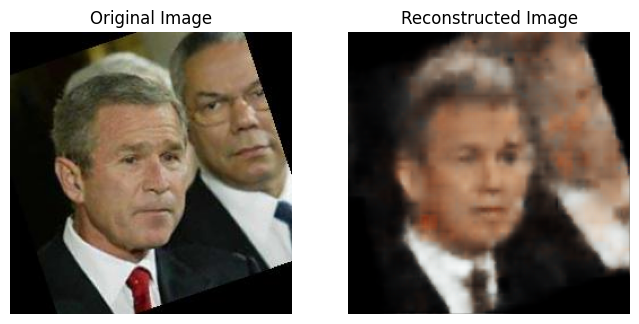

In [32]:
for i, data in enumerate(dataloader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    xt, _, _ = model(inputs)
    plot_image_pair(inputs[0], xt[0])
    break  # Only visualize the first batch for simplicitys